# **EEG signal processing**
* **Part 1: Signal Visualization and Analysis**
* **Part 2: Signal Resampling and Interpolation**
* **Part 3: Filtering Techniques**
* **Part 4: Convolution Filters**
* **Part 5: Feature Extraction**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##**Part 1: Signal Visualization and Analysis**


###**Task 1.1: Multi-Channel Visualization**

1. Load a subject file
2. Plot **all 19 channels** for the full 60-second duration
3. Select **TWO different channels (not Fp1)** and create individual plots with proper labels

**Deliverables:**

* Multi-channel plot showing all 19 channels
* Two individual channel plots with time axis
* Brief description (2–3 sentences) of any visible patterns or artifacts

---

In [4]:
sfreq = 512
ch_types = ['eeg']
ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz']

eeg = pd.read_csv('/content/s00.csv', names=ch_names)
eeg.shape

(31000, 19)

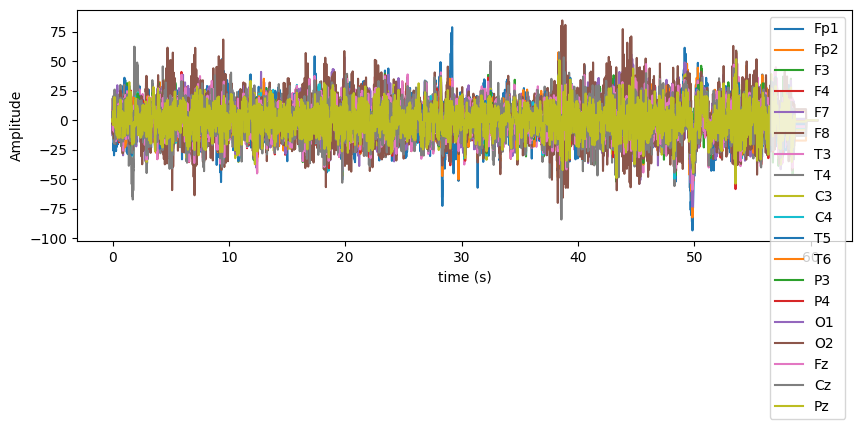

In [5]:
t = np.arange(len(eeg)) / sfreq
plt.figure(figsize=(10,3))

for i in range(len(ch_names)):
    plt.plot(t, eeg[ch_names[i]])
    plt.legend(ch_names,loc='best')


plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.show()

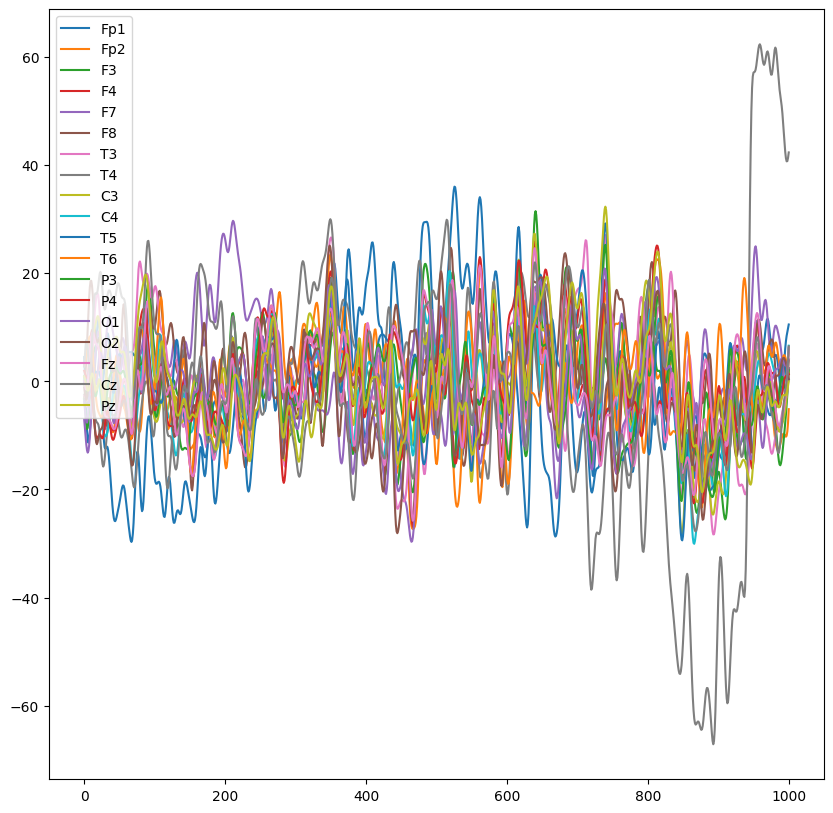

In [6]:

plt.figure(figsize=(10,10))

for i in range (19):
  plt.plot(eeg.iloc[:,i][:1000])
  plt.legend(ch_names,loc='upper left')
# plt.plot(signal['avg'][:1000],c='black',alpha=0.7)


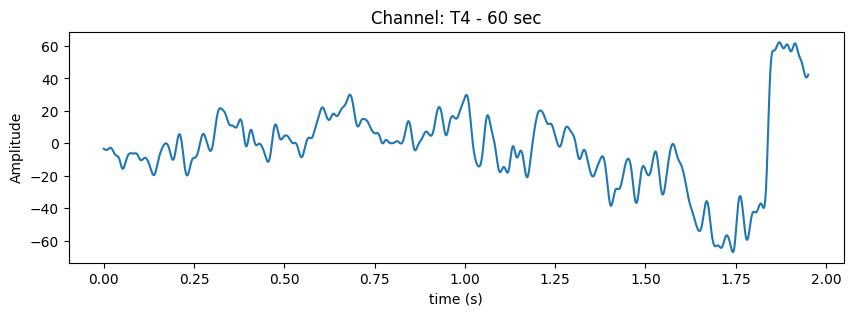

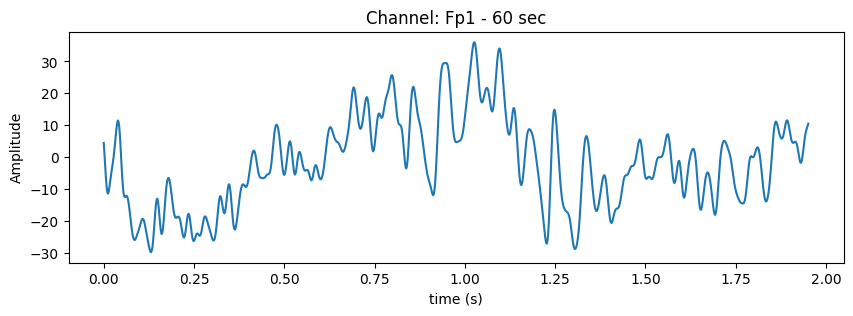

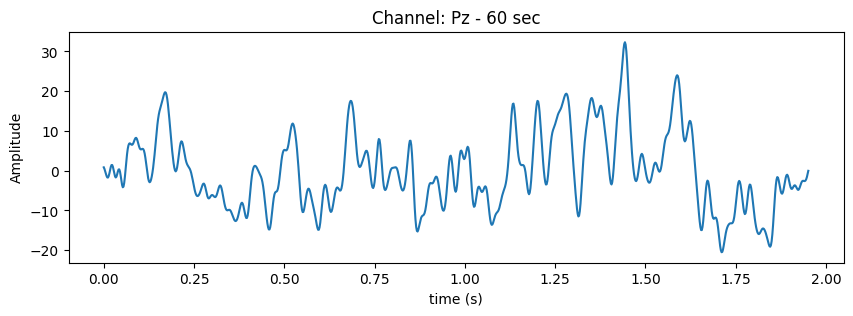

In [7]:
chosen_channels = ['T4', 'Fp1','Pz']
for ch in chosen_channels:
  plt.figure(figsize=(10,3))
  plt.plot(t[:1000], eeg[ch][:1000])
  plt.title(f"Channel: {ch} - 60 sec")
  plt.xlabel("time (s)")
  plt.ylabel("Amplitude")
  plt.show()

* **chaneel T4 looks like it has lots of artifacts or a ruined chaneel**
* **F1 ,F2 ,F8 is getting triggered more than the other chaneels**




###**Task 1.2: Frequency Domain Analysis**

1. Select one channel from your chosen subject
2. Plot both time domain and frequency domain (FFT) representations
3. Identify the dominant frequency components in the 0–60 Hz range

**Deliverables:**

* Time-frequency plots
* List the top 3 frequency peaks and their approximate magnitudes


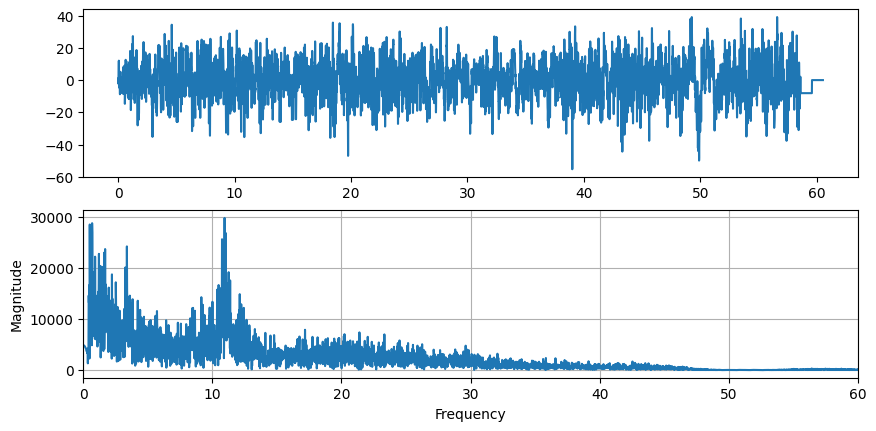

In [8]:
N=len(eeg)
tf = np.fft.fftfreq(N, d=1/sfreq)


plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(t, eeg['C3'])

fft_C3_magnitudes = np.abs(np.fft.fft(eeg['C3']))
flag= tf>=0
fft_C3_magnitudes=fft_C3_magnitudes[flag]
tf=tf[flag]

plt.subplot(412)
plt.plot(tf, fft_C3_magnitudes)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim([0, 60])
plt.show()

In [9]:
max_freq_index = np.argmax(fft_C3_magnitudes)
max_freq = tf[max_freq_index]
max_freq

np.float64(10.950193548387098)

In [10]:
top_3i=np.argsort(fft_C3_magnitudes)[-3:][::-1]
top_3_mag=fft_C3_magnitudes[top_3i]
top_3_freq=tf[top_3i]
print("top 3 frequencies")
for freq,mag in zip(top_3_freq,top_3_mag):
  print(f"freq:{freq}, it's magnitude:{mag}")


top 3 frequencies
freq:10.950193548387098, it's magnitude:29809.982926759276
freq:0.6936774193548387, it's magnitude:28778.863309054606
freq:0.512, it's magnitude:28524.857576197137


##**Part 2: Signal Resampling and Interpolation**


###**Task 2.1: Downsampling Experiment**

Perform downsampling with **THREE different target frequencies:**

* **64 Hz**
* **128 Hz (as in the lab)**
* **256 Hz**

**Requirements:**

* Visualize the first **0.5 seconds**
* Create comparison plots for all three downsampled versions in (time domain and frequency domain)

**Deliverables:**

* Three separate subplot figures showing original vs. downsampled signals
* Discussion: Which downsampling rate preserves signal quality better? Why?


In [11]:
def downsample(t, signal, sfreq, new_sfreq):
    step = sfreq // new_sfreq
    new_t = t[::step]
    new_signal = signal[::step]
    return new_t, new_signal

def time_freq(signal, time, sfreq, right=True):
    n = int(time * sfreq)
    tf = np.fft.fftfreq(n, d=1/sfreq)
    fft_magnitudes = np.abs(np.fft.fft(signal[:n]))
    if right:
        flag = tf>=0
        fft_magnitudes = fft_magnitudes[flag]
        tf = tf[flag]

    return tf, fft_magnitudes

def plt_time(ax, t, signal, n, title):
    ax.plot(t[:n], signal[:n], marker='o', linestyle='-')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.set_title(title)

def plt_freq(ax, tf, fft_magnitudes, title):
    ax.plot(tf, fft_magnitudes)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlim([0, 256])

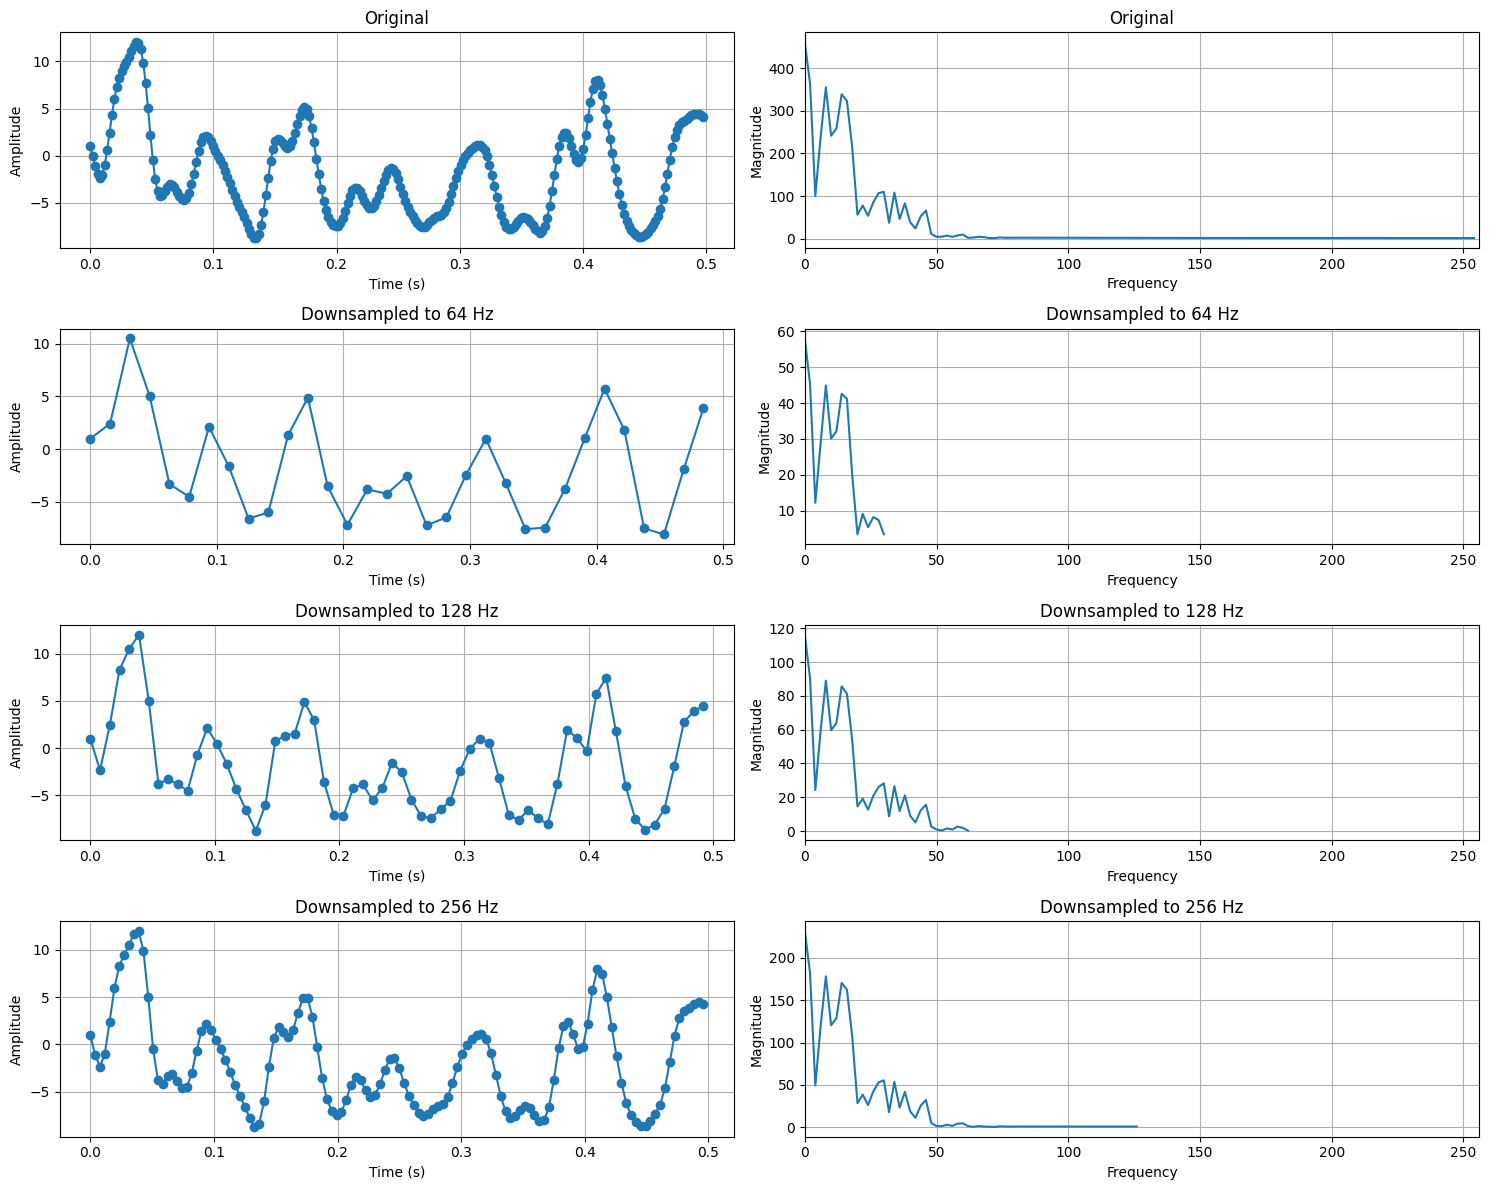

In [12]:
dfs = [sfreq, 64, 128, 256]
c3 = eeg['C3'].values
fig, ax = plt.subplots(4, 2, figsize=(15, 12))


for i in range(len(dfs)):
    n = int(0.5 * dfs[i])
    downsampled_t, downsampled_c3 = downsample(t, c3, sfreq, dfs[i])
    tf, fft_magnitudes = time_freq(downsampled_c3, 0.5, dfs[i])

    title = f"Downsampled to {dfs[i]} Hz" if i > 0 else "Original"
    plt_time(ax[i][0], downsampled_t, downsampled_c3, n, title)
    plt_freq(ax[i][1], tf, fft_magnitudes, title)

plt.tight_layout()
plt.show()

**128 down-sampling rate preservs the signal quality and is so close to 256 down-sampling rate in resolution , so 128 down-sampling rate is more effecient**

###**Task 2.2: IDW Interpolation with Different Powers**

Apply IDW interpolation using **different power parameters:**

* **power = 1**
* **power = 2 (as in lab)**
* **power = 4**

**Requirements:**

* Downsample to 64 Hz first
* Upsample back to original 512 Hz using each power value
* Compare the results visually

**Deliverables:**

* Three upsampled signal plots with different power values
* Analysis: How does the power parameter affect interpolation smoothness?


In [13]:
def get_distance(t, new_t):
  m = len(new_t)
  n = len(t)
  t = t.reshape(1, -1)
  t.repeat(m, axis=0)
  new_t = new_t.reshape(-1, 1)
  return np.abs(t - new_t)

def idw(t, signal, new_t, power):
    distance = get_distance(t, new_t)
    original_rows = np.any(distance == 0, axis=1)
    new_rows = original_rows == False

    distance = distance[new_rows]
    wights = 1 / (distance ** power)
    idw = np.dot(wights, signal) / np.sum(wights, axis=1)

    new_signal = np.zeros(len(new_t))
    new_signal[original_rows] = signal
    new_signal[new_rows] = idw
    return new_signal

def idw_upsample(t, signal, power, sfreq, new_sfreq):
  min_t = np.min(t)
  max_t = np.max(t)
  new_t = np.arange(min_t, max_t + 1/new_sfreq, 1/new_sfreq)
  upsampled_signal = idw(t, signal, new_t, power)
  return new_t, upsampled_signal

In [14]:
downsampled_t, downsampled_c3 = downsample(t, c3, sfreq, 64)
tf, fft_magnitudes = time_freq(downsampled_c3, 0.5, 64)

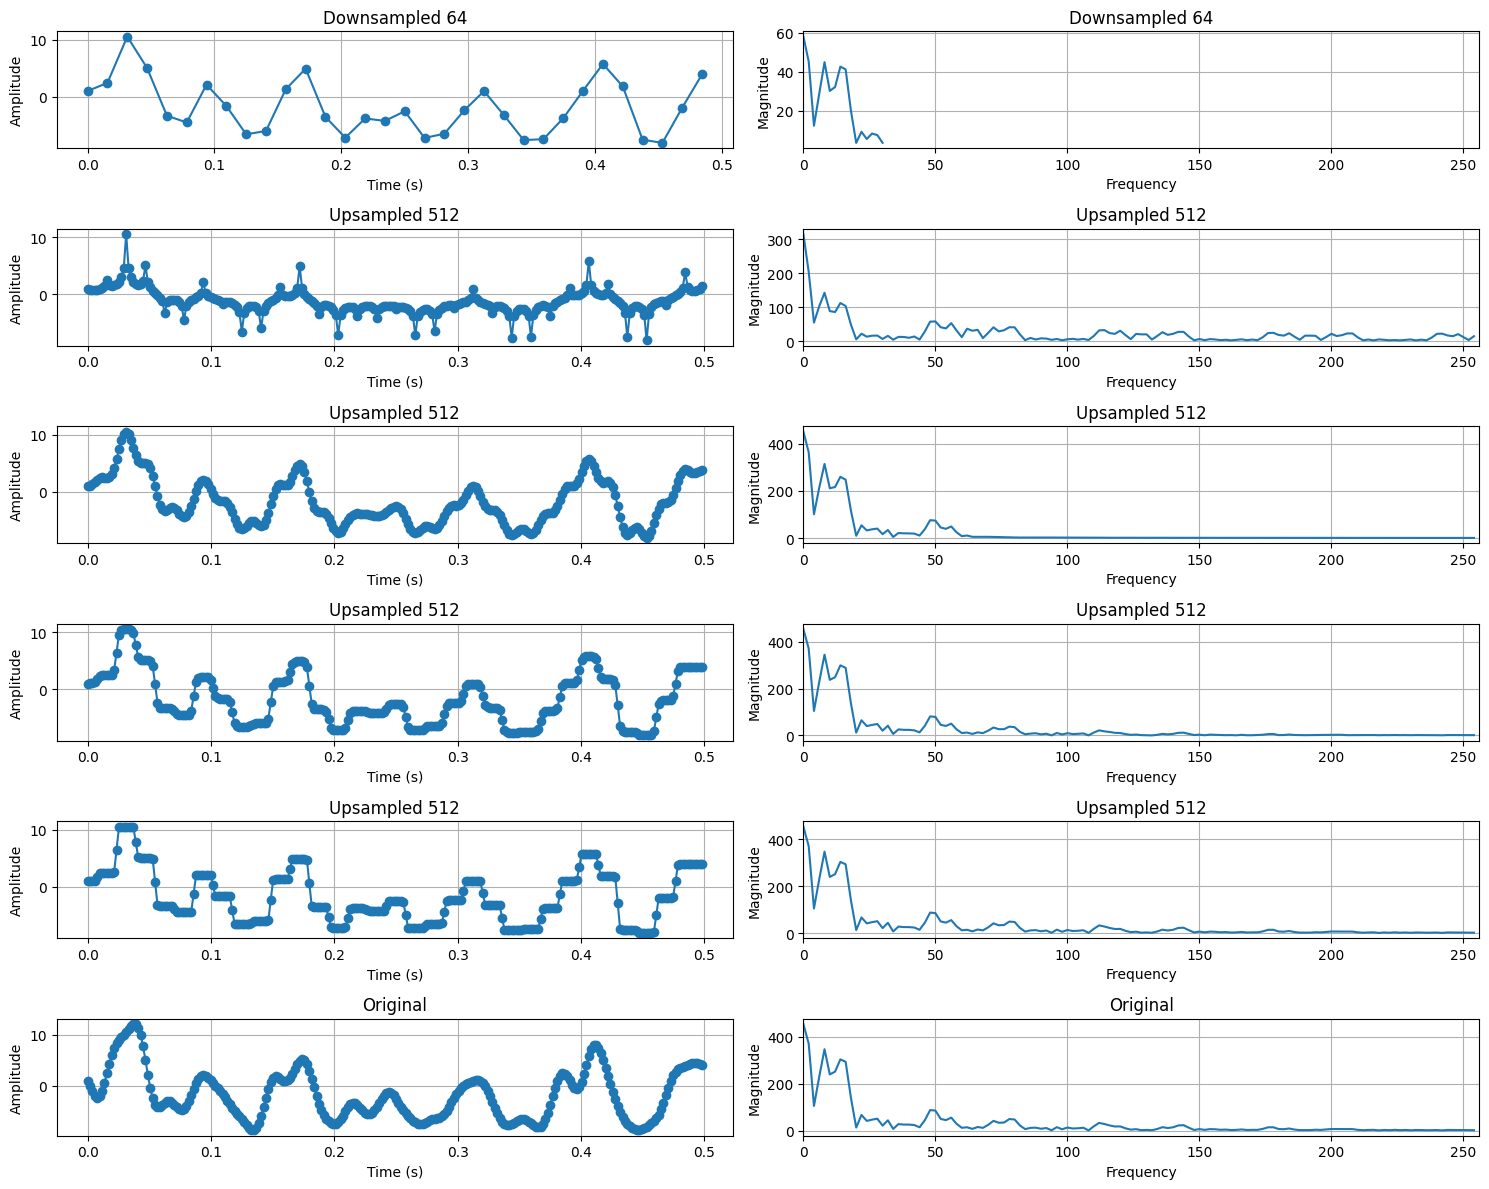

In [15]:
fig, ax = plt.subplots(6, 2, figsize=(15, 12))
plt_time(ax[0][0], downsampled_t, downsampled_c3, 32, "Downsampled 64")
plt_freq(ax[0][1], tf, fft_magnitudes, "Downsampled 64")
powers = [1, 2, 4, 8]
for i, power in enumerate(powers):
    upsampled_t, upsampled_c3 = idw_upsample(downsampled_t, downsampled_c3, power, 64, 512)
    tf, fft_magnitudes = time_freq(upsampled_c3, 0.5, 512)
    plt_time(ax[i+1][0], upsampled_t, upsampled_c3, 256, "Upsampled 512")
    plt_freq(ax[i+1][1], tf, fft_magnitudes, "Upsampled 512")

plt_time(ax[-1][0], t, c3, 256, "Original")
plt_freq(ax[-1][1], tf, fft_magnitudes, "Original")

plt.tight_layout()
plt.show()



*   **power 1:most smooth**
*   **power 2: less smooth than power 1 , nearby samples has more effect but still modrate smoothing**
* **power 4 or higher: sharp signal because weight drops too much, almost nearest nighbour**



##**Part 3: Filtering Techniques**

###**Task 3.1: Butterworth Filters**

**High-Pass Filter Experiment:** Test with cutoff frequencies: **20 Hz, 30 Hz, 40 Hz**

**Low-Pass Filter Experiment:** Test with cutoff frequencies: **30 Hz, 40 Hz, 50 Hz**

**Requirements:**

* Apply each filter separately to your selected channel
* Use filter order = 4
* Plot time domain AND frequency domain for each filtered signal
* Compare with the original signal

**Deliverables:**

* 6 time-frequency plot pairs (3 high-pass + 3 low-pass)
* Table summarizing the effect of each cutoff frequency on signal characteristics

In [16]:
import scipy.signal

def low_pass_f(signal, cutoff, sfreq=sfreq, order=4):
  norm_cutoff = cutoff / ( 0.5*sfreq)
  b, a = scipy.signal.butter(order, norm_cutoff, btype='low', analog=False)
  filtered= scipy.signal.filtfilt(b, a, signal)
  return filtered

def high_pass_f(signal, cutoff, sfreq=sfreq, order=4):
  norm_cutoff = cutoff / ( 0.5*sfreq)
  b, a = scipy.signal.butter(order, norm_cutoff, btype='high', analog=False)
  filtered= scipy.signal.filtfilt(b, a, signal)
  return filtered



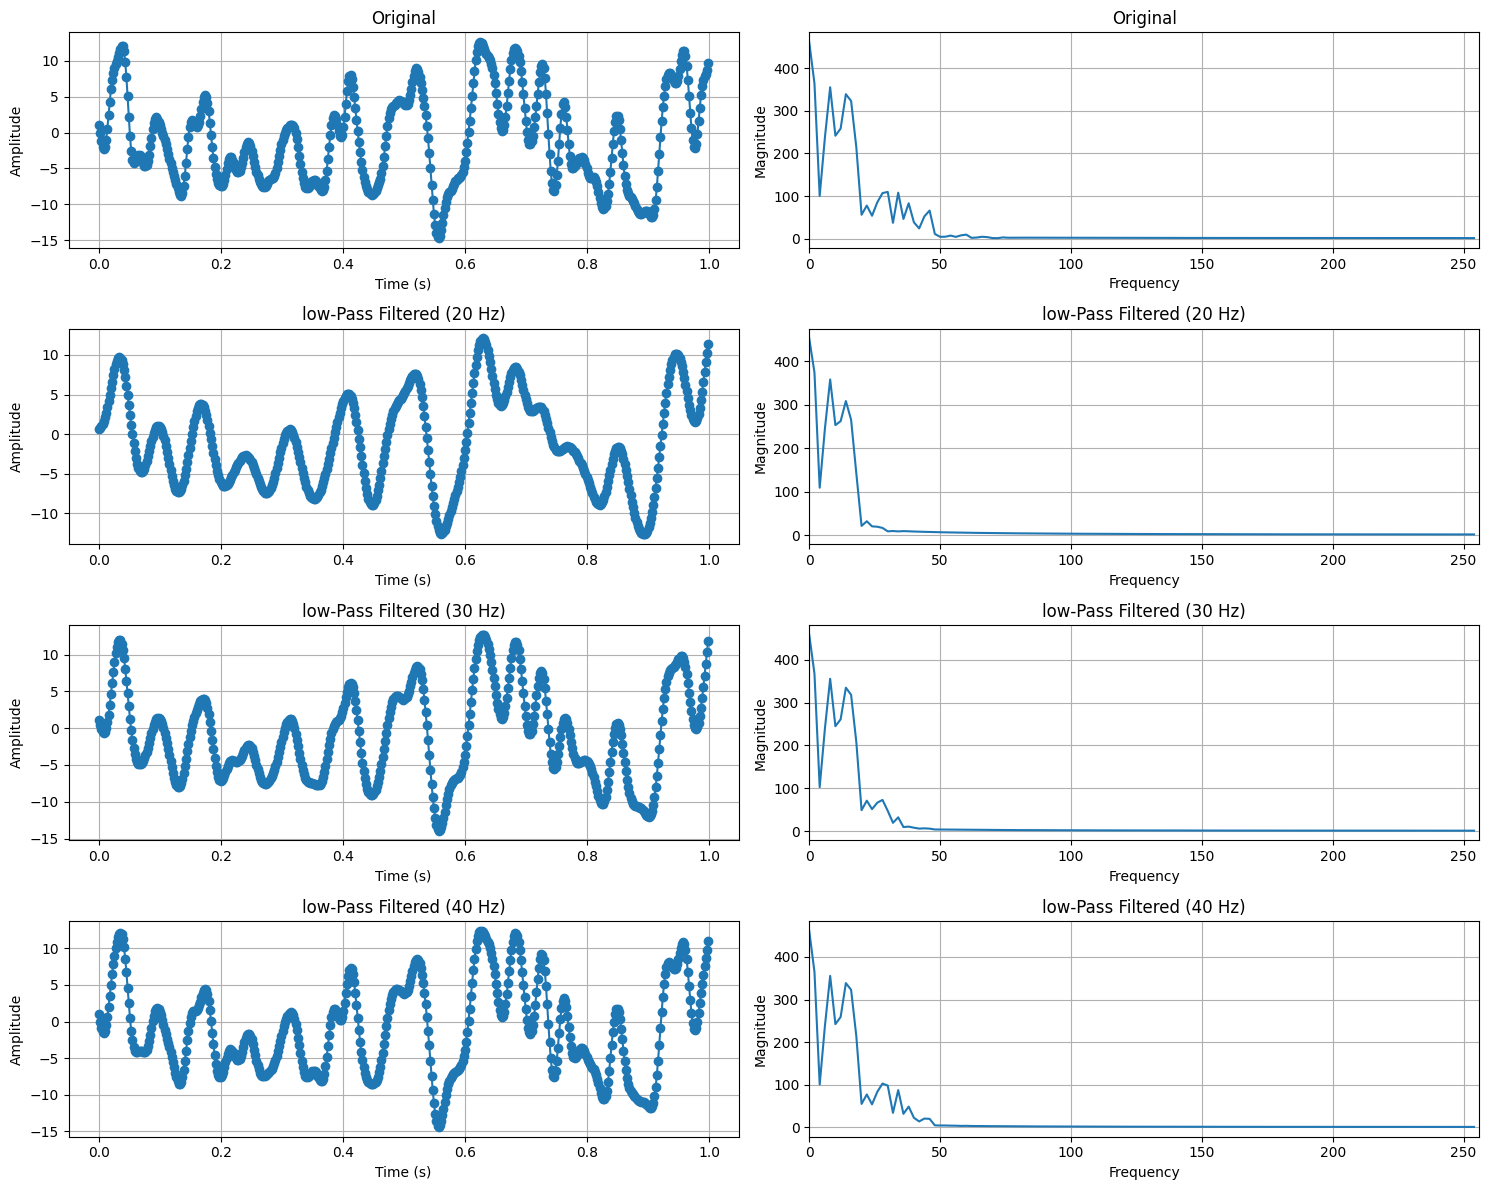

In [17]:
f_freq=[20,30,40]

fig, ax = plt.subplots(4, 2, figsize=(15, 12))


plt_time(ax[0][0], t, c3, 512, "Original")
tf_orig, fft_magnitudes_orig = time_freq(c3, 0.5, sfreq)
plt_freq(ax[0][1], tf_orig, fft_magnitudes_orig, "Original")

for i, freq in enumerate(f_freq):
    filtered_c3 = low_pass_f(c3, freq)
    tf_filtered, fft_magnitudes_filtered = time_freq(filtered_c3, 0.5, sfreq)
    plt_time(ax[i+1][0], t, filtered_c3, 512, f"low-Pass Filtered ({freq} Hz)")
    plt_freq(ax[i+1][1], tf_filtered, fft_magnitudes_filtered, f"low-Pass Filtered ({freq} Hz)")

plt.tight_layout()
plt.show()

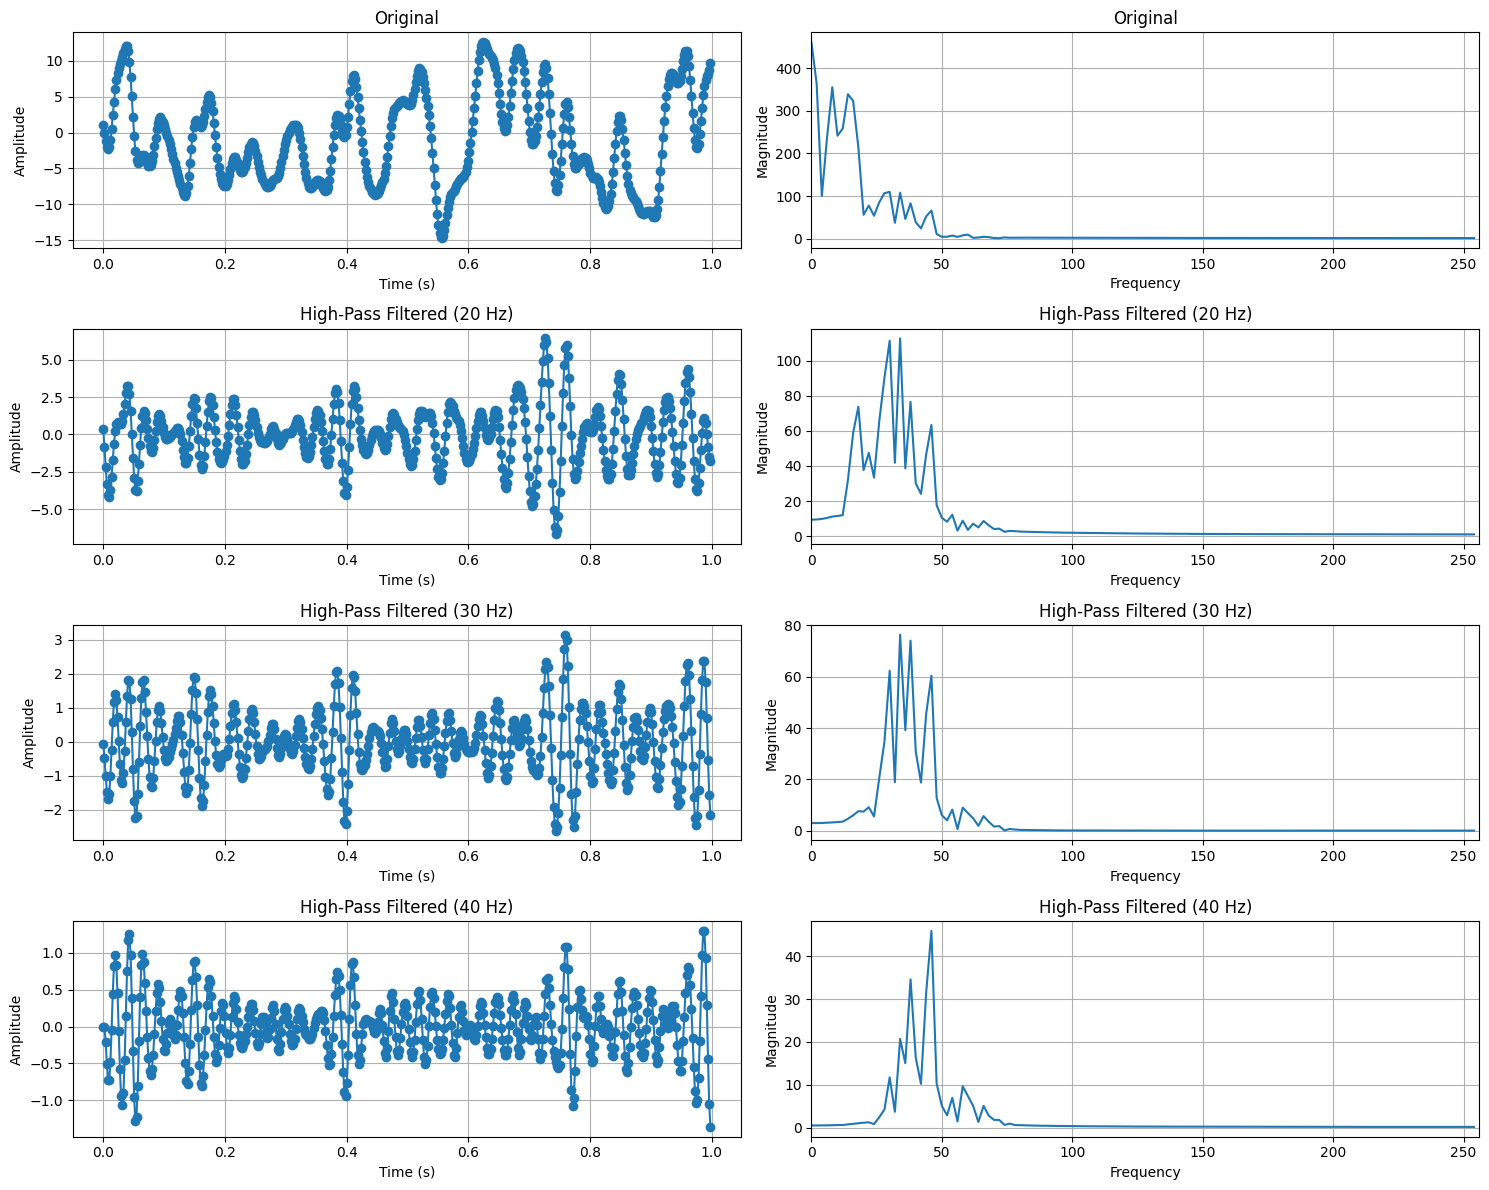

In [18]:
f_freq=[20,30,40]

fig, ax = plt.subplots(4, 2, figsize=(15, 12))


plt_time(ax[0][0], t, c3, 512, "Original")
tf_orig, fft_magnitudes_orig = time_freq(c3, 0.5, sfreq)
plt_freq(ax[0][1], tf_orig, fft_magnitudes_orig, "Original")

for i, freq in enumerate(f_freq):
    filtered_c3 = high_pass_f(c3, freq)
    tf_filtered, fft_magnitudes_filtered = time_freq(filtered_c3, 0.5, sfreq)
    plt_time(ax[i+1][0], t, filtered_c3, 512, f"High-Pass Filtered ({freq} Hz)")
    plt_freq(ax[i+1][1], tf_filtered, fft_magnitudes_filtered, f"High-Pass Filtered ({freq} Hz)")

plt.tight_layout()
plt.show()

In [ ]:
all_c3_filtered_features = {
    'Original C3': extract_features(c3)
}
for i in [20,30,40]:
  low_pass_filtered = low_pass_f(c3,i)
  low_pass_filtered_clean = low_pass_filtered[~np.isnan(low_pass_filtered)]
  all_c3_filtered_features[f'Low-Pass {i}Hz C3'] = extract_features(low_pass_filtered_clean)

  high_pass_filtered = high_pass_f(c3,i)
  high_pass_filtered_clean= high_pass_filtered[~np.isnan(high_pass_filtered)]
  all_c3_filtered_features[f'High-Pass {i}Hz C3'] = extract_features(high_pass_filtered_clean)

In [39]:

c3_comparison_table = pd.DataFrame(all_c3_filtered_features).T
print(c3_comparison_table)

                         Energy        RMS       Peak  Amplitude  Skewness  \
Original C3        4.218782e+06  11.665751  55.330000  94.455000 -0.187686   
Low-Pass 20Hz C3   3.799661e+06  11.071121  51.139334  88.403124 -0.187820   
High-Pass 20Hz C3  2.289520e+05   2.717637  14.424527  27.316592  0.008513   
Low-Pass 30Hz C3   4.086762e+06  11.481770  54.818923  92.844125 -0.189607   
High-Pass 30Hz C3  4.350834e+04   1.184692  10.497388  19.538059  0.014555   
Low-Pass 40Hz C3   4.182042e+06  11.614842  55.281223  94.167381 -0.188818   
High-Pass 40Hz C3  7.356826e+03   0.487152   5.532928  10.332135  0.033636   

                   Kurtosis  Crest Factor  Shape Factor  Impulse Factor  \
Original C3        0.442055      4.742944      1.282185        6.081333   
Low-Pass 20Hz C3   0.515504      4.619165      1.282862        5.925751   
High-Pass 20Hz C3  0.311998      5.307747      1.283848        6.814339   
Low-Pass 30Hz C3   0.460784      4.774431      1.282249        6.122011   


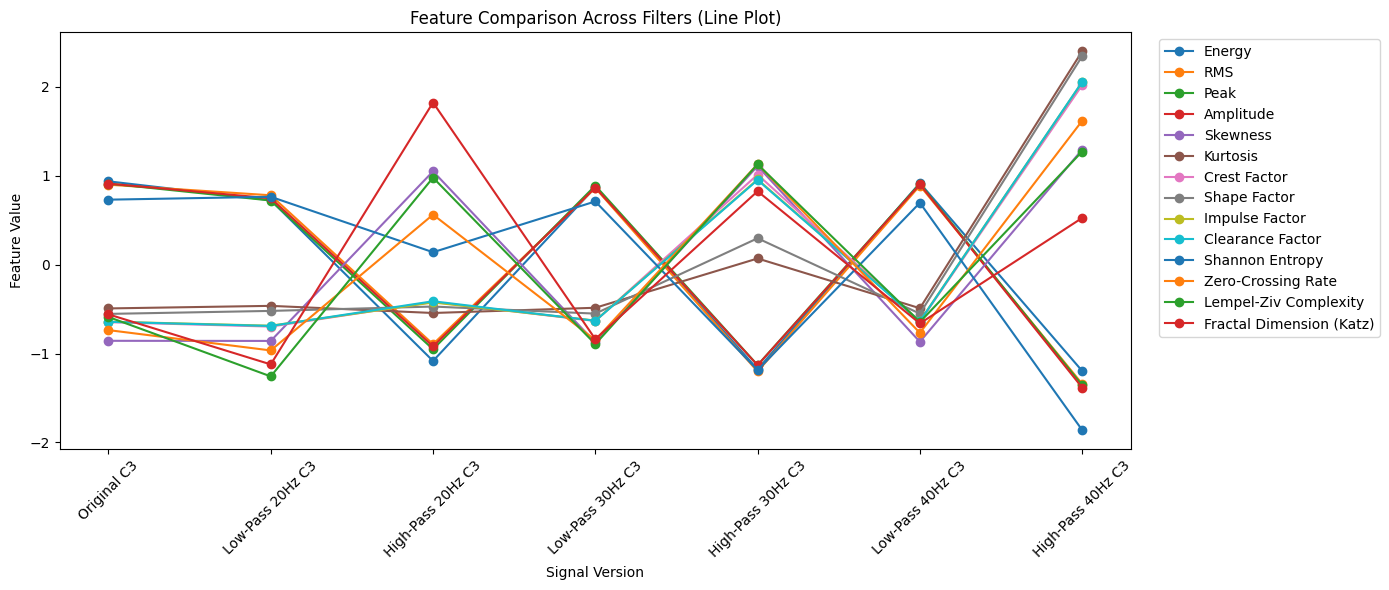

In [60]:
from scipy.stats import zscore


features_to_plot = [
    'Energy', 'RMS', 'Peak', 'Amplitude', 'Skewness', 'Kurtosis',
    'Crest Factor','Shape Factor','Impulse Factor','Clearance Factor',
    'Shannon Entropy', 'Zero-Crossing Rate', 'Lempel-Ziv Complexity',
    'Fractal Dimension (Katz)'
]


normalized_table = c3_comparison_table.copy()
normalized_table = normalized_table.apply(lambda col: zscore(col, nan_policy='omit'))

plt.figure(figsize=(14, 6))

for feature in features_to_plot:
    plt.plot(normalized_table.index, normalized_table[feature], marker='o', label=feature)

plt.xticks(rotation=45)
plt.title("Feature Comparison Across Filters (Line Plot)")
plt.xlabel("Signal Version")
plt.ylabel("Feature Value")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


###**Task 3.2: Notch Filter for Powerline Noise**

Apply notch filters at:

* **50 Hz (European standard)**
* **60 Hz (US standard)**
* **10 Hz (as in example)**

Test with two different quality factors: **Q = 10** and **Q = 30**

**Deliverables:**

* Frequency domain plots showing notch effect for each configuration
* Discussion: Which combination (frequency + Q factor) is most effective for removing noise?


In [19]:
def notch_f(signal,notch_f, Q, sfreq=sfreq):
  b, a = scipy.signal.iirnotch(notch_f, Q, sfreq)
  filtered= scipy.signal.filtfilt(b, a, signal)
  return filtered

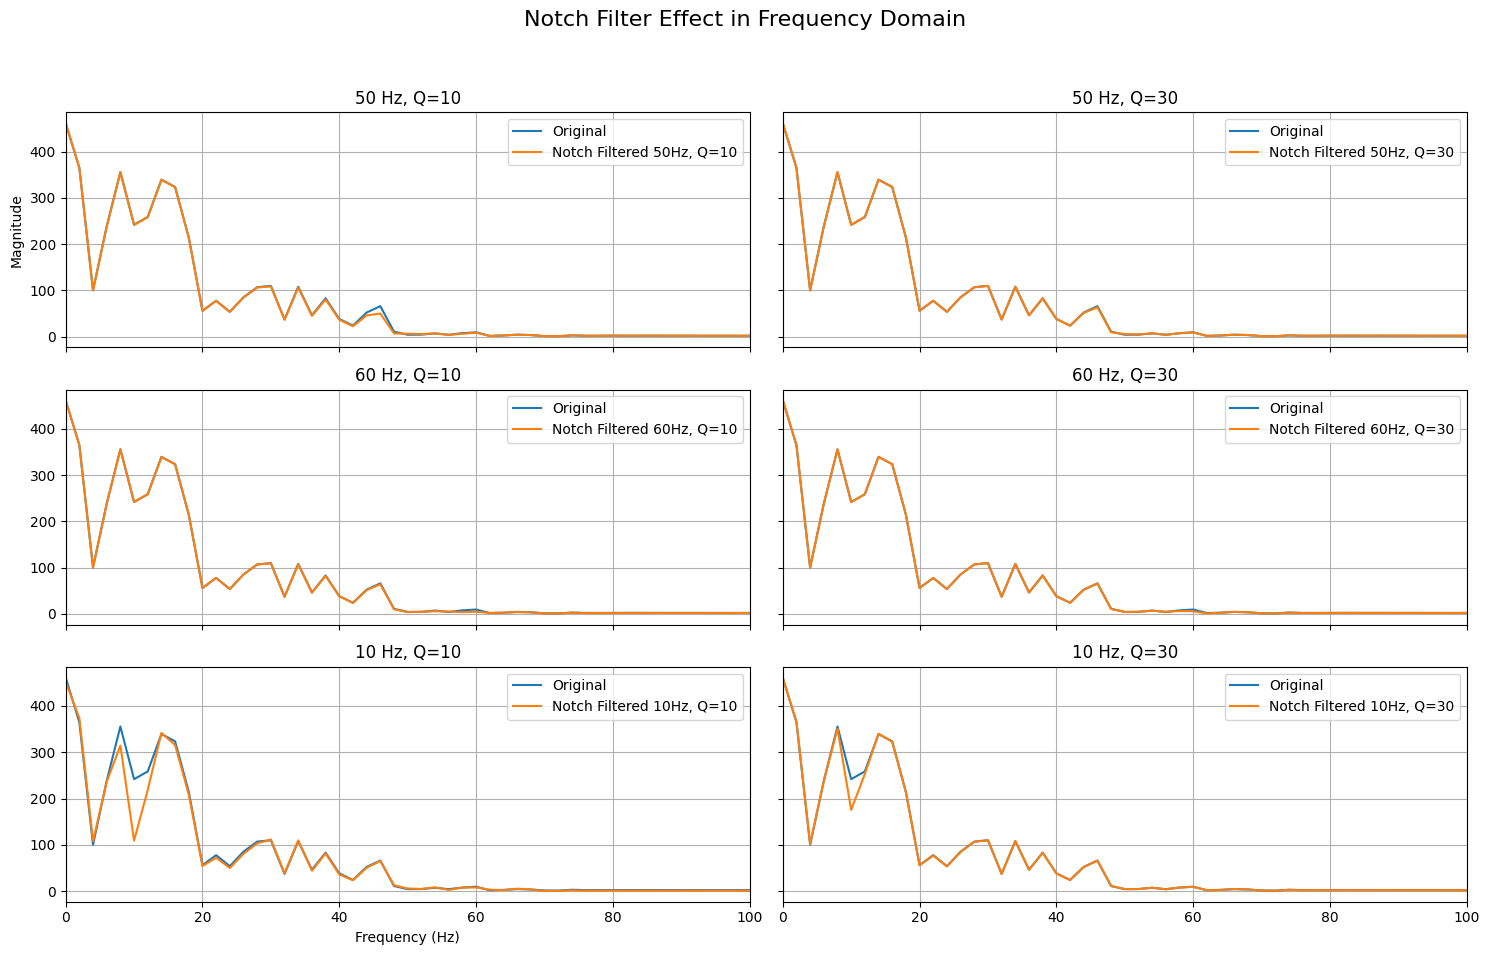

In [20]:
notch_freqs=[50,60,10]
Qs=[10,30]

fig, ax = plt.subplots(len(notch_freqs), len(Qs), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Notch Filter Effect in Frequency Domain', fontsize=16)

tf_orig, fft_magnitudes_orig = time_freq(c3, 0.5, sfreq)

for i, n_freq in enumerate(notch_freqs):
    for j, q_val in enumerate(Qs):
        filtered_c3 = notch_f(c3, n_freq, q_val)
        tf_filtered, fft_magnitudes_filtered = time_freq(filtered_c3, 0.5, sfreq)

        ax[i, j].plot(tf_orig, fft_magnitudes_orig, label='Original')
        ax[i, j].plot(tf_filtered, fft_magnitudes_filtered, label=f'Notch Filtered {n_freq}Hz, Q={q_val}')
        ax[i, j].set_title(f'{n_freq} Hz, Q={q_val}')
        ax[i, j].set_xlim([0, 100])
        ax[i, j].legend()
        ax[i, j].grid(True)


ax[-1, 0].set_xlabel('Frequency (Hz)')
ax[0, 0].set_ylabel('Magnitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

يعني ايه


##**Part 4: Convolution Filters**

###**Task 4.1: Box Filter (Moving Average)**

Experiment with different kernel sizes:

* kernel_size = 20
* kernel_size = 50
* kernel_size = 150

Deliverables:

* Three filtered signal plots
* Comparison: How does kernel size affect smoothing?

In [21]:
from scipy.signal import convolve

def box_f(signal, kernel_size):
  kernel = np.ones(kernel_size) / kernel_size
  filtered = convolve(signal, kernel, mode='same')
  return filtered

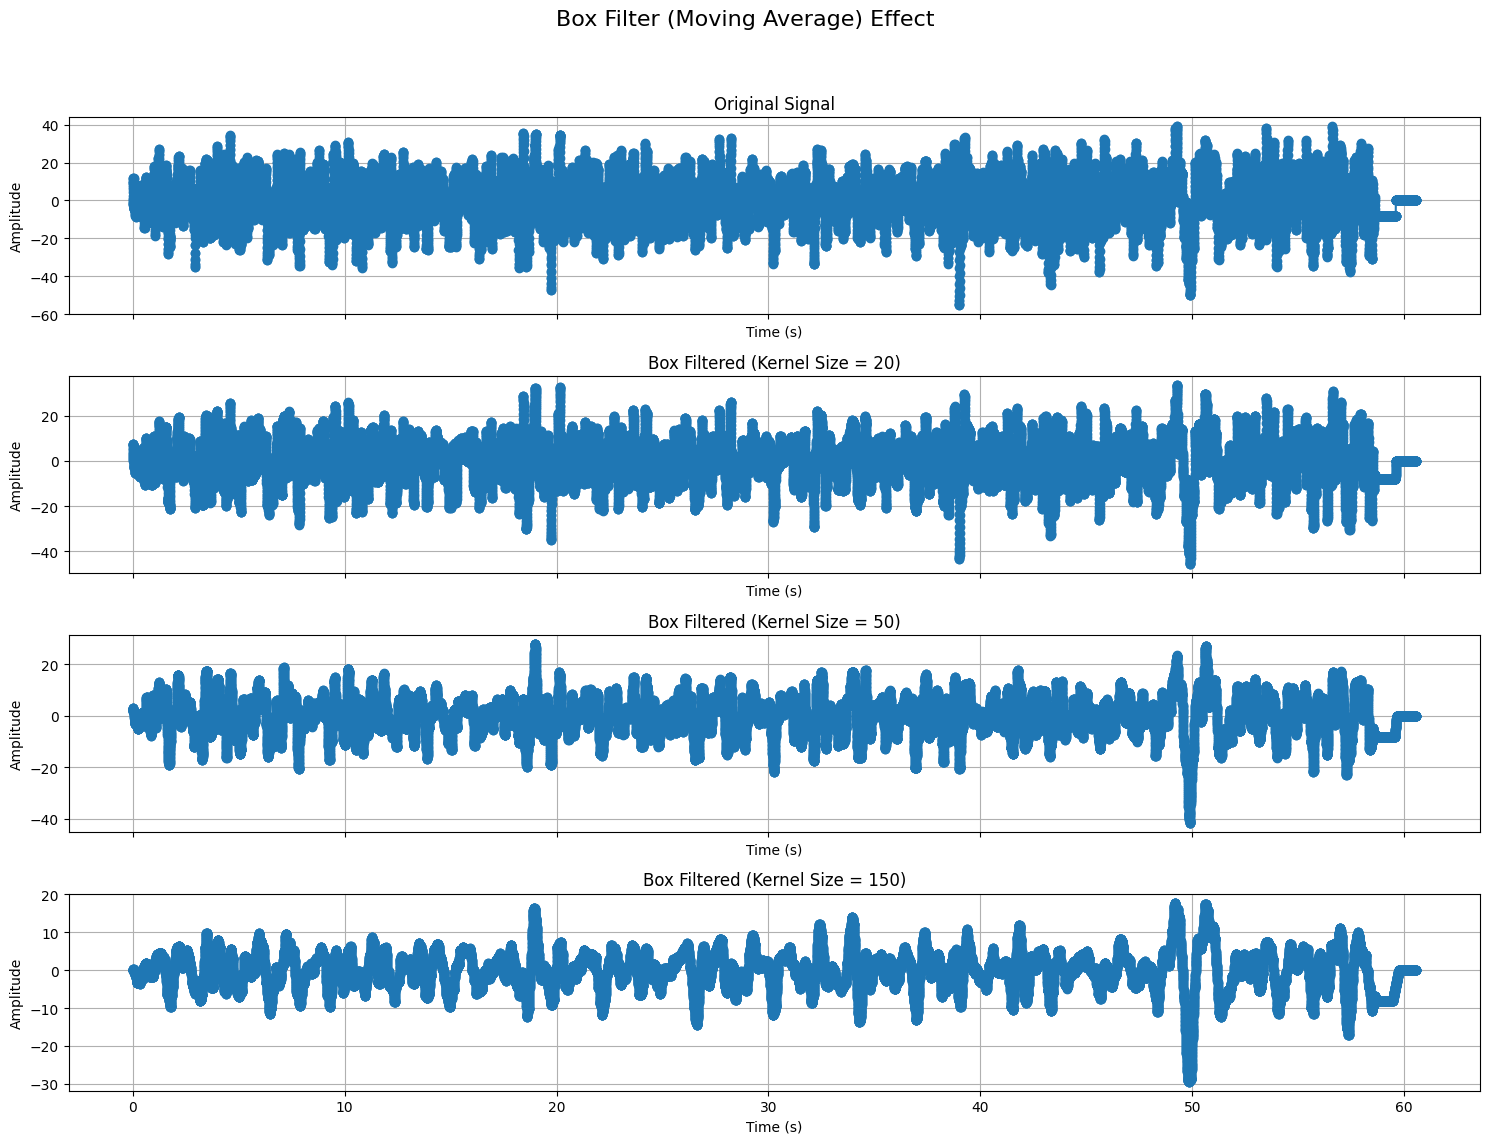

In [22]:
kernals=[20,50,150]

fig, ax = plt.subplots(len(kernals) + 1, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Box Filter (Moving Average) Effect', fontsize=16)

# Plot original signal
plt_time(ax[0], t, c3, len(t), "Original Signal")

for i, kernel_size in enumerate(kernals):
    filtered_c3 = box_f(c3, kernel_size)
    plt_time(ax[i+1], t, filtered_c3, len(t), f"Box Filtered (Kernel Size = {kernel_size})")

ax[-1].set_xlabel('Time (s)')
ax[int(len(kernals)/2)].set_ylabel('Amplitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**higher kernal size results in a more smooth signal**


###**Task 4.2: Gaussian Filter**

Test different sigma values:

* sigma = 3
* sigma = 10
* sigma = 20

Deliverables:

* Three filtered signal plots
* Analysis: Compare Gaussian Filter vs. Box Filter for smoothing effectiveness


In [23]:
from scipy.ndimage import gaussian_filter1d

def gauss_f(signal, sigma):
  filtered= gaussian_filter1d(signal, sigma,mode='reflect')
  return filtered


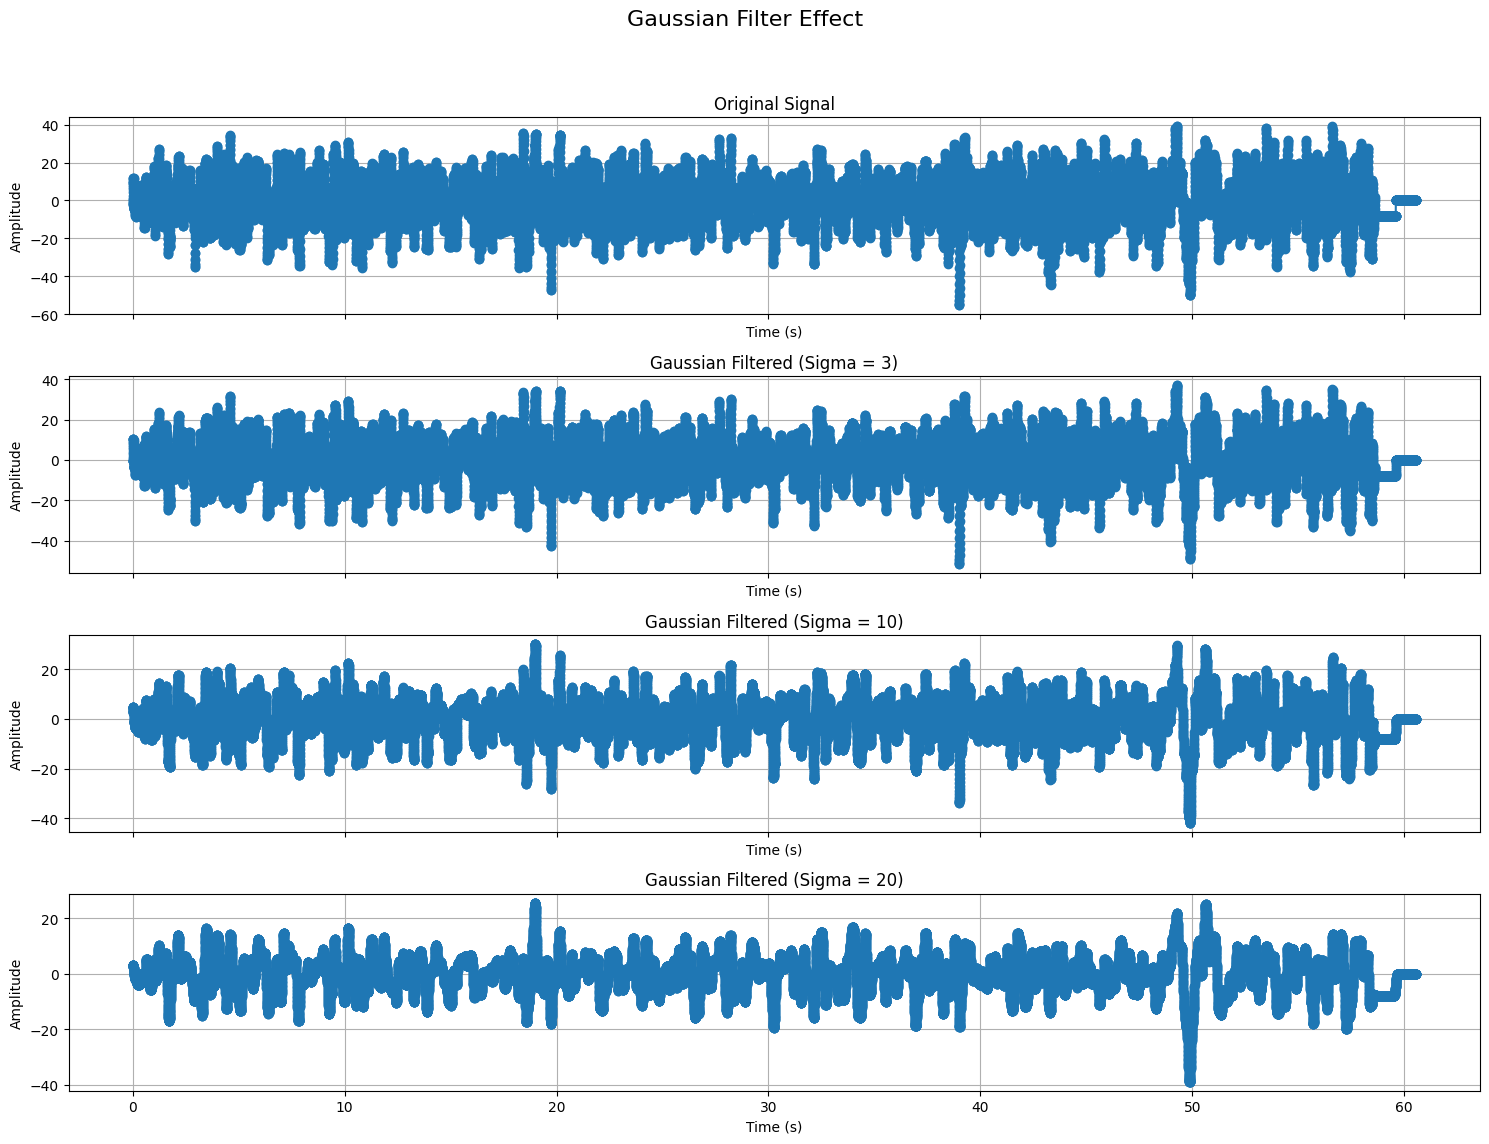

In [24]:

sigmas = [3, 10, 20]

fig, ax = plt.subplots(len(sigmas) + 1, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Gaussian Filter Effect', fontsize=16)


plt_time(ax[0], t, c3, len(t), "Original Signal")

for i, sigma_val in enumerate(sigmas):
    filtered_c3_gaussian = gauss_f(c3, sigma_val)
    plt_time(ax[i+1], t, filtered_c3_gaussian, len(t), f"Gaussian Filtered (Sigma = {sigma_val})")

ax[-1].set_xlabel('Time (s)')
ax[int(len(sigmas)/2)].set_ylabel('Amplitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Box filter results in a more smooth signal**

##**Part 5: Feature Extraction**

###**Task 5.1: Extract Features from Multiple Channels**

1. Select **THREE different channels** from your dataset
2. Apply the **extract_features()** function to each channel
3. Create a comparison table showing all extracted features

**Features to Extract:**

* Energy, RMS, Peak, Amplitude
* Skewness, Kurtosis
* Crest Factor, Shape Factor, Impulse Factor, Clearance Factor
* Shannon Entropy
* Zero-Crossing Rate (ZCR)
* Lempel-Ziv Complexity
* Fractal Dimension

**Deliverables:**

* Feature comparison table (3 channels × all features)
* Analysis: Which channel shows the highest complexity? Why might this be?

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy

def energy_feature(signal):
    signal = np.asarray(signal)
    return np.sum(signal**2)

def rms_feature(signal):
    signal = np.asarray(signal)
    return np.sqrt(np.mean(signal**2))

def peak_feature(signal):
    signal = np.asarray(signal)
    return np.max(np.abs(signal))

def amplitude_feature(signal):
    signal = np.asarray(signal)
    return np.ptp(signal)

def skewness_feature(signal):
    signal = np.asarray(signal)
    return skew(signal)

def kurtosis_feature(signal):
    signal = np.asarray(signal)
    return kurtosis(signal)

def crest_factor_feature(signal):
    rms_val = rms_feature(signal)
    p = peak_feature(signal)
    return p / rms_val

def shape_factor_feature(signal):
    signal = np.asarray(signal)
    mean_abs_val = np.mean(np.abs(signal))
    r = rms_feature(signal)
    return r / mean_abs_val

def impulse_factor_feature(signal):
    signal = np.asarray(signal)
    mean_abs_val = np.mean(np.abs(signal))
    p = peak_feature(signal)
    return p / mean_abs_val

def clearance_factor_feature(signal):
    signal = np.asarray(signal)
    sqrt_mean_sqrt_abs = np.mean(np.sqrt(np.abs(signal)))**2
    p = peak_feature(signal)
    return p / sqrt_mean_sqrt_abs

def shannon_entropy_feature(signal, bins=10):
    signal = np.asarray(signal)
    hist, bin_edges = np.histogram(signal, bins=bins, density=False)
    prob = hist.astype(float) / np.sum(hist)
    prob = prob[prob > 0]
    return entropy(prob)

def zcr_feature(signal):
    signal = np.asarray(signal)
    n = len(signal)
    s = np.sign(signal)
    s[s == 0] = 1
    zero_crossings = np.sum(s[:-1] != s[1:])
    return zero_crossings / (n - 1)

def lempel_ziv_complexity(signal):

    x = np.asarray(signal)
    n = len(x)
    med = np.median(x)
    b = (x >= med).astype(int)
    s = ''.join(b.astype(str))
    i = 0
    c = 1
    l = 1
    while True:
        if i + l > n:
            break
        sub = s[i:i+l]
        found = False
        # search sub in previous part
        for j in range(0, i):
            if s[j:j+l] == sub:
                found = True
                break
        if not found:
            c += 1
            i += l
            l = 1
        else:
            l += 1
        if i + l > n:
            break
    return c


def katz_fractal_dimension(signal):

    # Katz fractal dimension: FD = log10(n) / (log10(n) + log10(d/L))

    x = np.asarray(signal).astype(float)
    n = len(x)
    diffs = np.abs(np.diff(x))
    L = np.sum(diffs)
    # distances from first point
    dists = np.abs(x - x[0])
    d = np.max(dists)
    if L == 0 or d == 0:
        return np.nan
    return np.log10(n) / (np.log10(n) + np.log10(d / L))

def extract_features(signal):
    features = {
        'Energy': energy_feature(signal),
        'RMS': rms_feature(signal),
        'Peak': peak_feature(signal),
        'Amplitude': amplitude_feature(signal),
        'Skewness': skewness_feature(signal),
        'Kurtosis': kurtosis_feature(signal),
        'Crest Factor': crest_factor_feature(signal),
        'Shape Factor': shape_factor_feature(signal),
        'Impulse Factor': impulse_factor_feature(signal),
        'Clearance Factor': clearance_factor_feature(signal),
        'Shannon Entropy': shannon_entropy_feature(signal),
        'Zero-Crossing Rate': zcr_feature(signal),
        'Lempel-Ziv Complexity': lempel_ziv_complexity(signal),
        'Fractal Dimension (Katz)': katz_fractal_dimension(signal)
    }
    for f in features:
        val = features[f]
        if isinstance(val, (int, np.integer)):
            print(f"{f}: {val}")
        else:
            try:
                print(f"{f}: {val:.4f}")
            except:
                print(f"{f}: {val}")
    return features


In [26]:
features_c3= extract_features(eeg['C3'])
print("="*100)
# features_f3= extract_features(eeg['F3'])
# print("="*100)
# features_o1= extract_features(eeg['O1'])
# print("="*100)
features_t4= extract_features(eeg['T4'])
print("="*100)
features_cz= extract_features(eeg['Cz'])
print("="*100)
features_fp1= extract_features(eeg['Fp1'])
print("="*100)
features_pz= extract_features(eeg['Pz'])
print("="*100)


Energy: 4218782.3393
RMS: 11.6658
Peak: 55.3300
Amplitude: 94.4550
Skewness: -0.1877
Kurtosis: 0.4421
Crest Factor: 4.7429
Shape Factor: 1.2822
Impulse Factor: 6.0813
Clearance Factor: 7.3509
Shannon Entropy: 1.6542
Zero-Crossing Rate: 0.0415
Lempel-Ziv Complexity: 508
Fractal Dimension (Katz): 2.6716
Energy: 5503839.8731
RMS: 13.3245
Peak: 67.1510
Amplitude: 129.4980
Skewness: -0.0327
Kurtosis: 1.3303
Crest Factor: 5.0397
Shape Factor: 1.3087
Impulse Factor: 6.5956
Clearance Factor: 8.0277
Shannon Entropy: 1.4678
Zero-Crossing Rate: 0.0410
Lempel-Ziv Complexity: 499
Fractal Dimension (Katz): 2.6355
Energy: 5506245.5863
RMS: 13.3274
Peak: 84.0970
Amplitude: 141.6790
Skewness: -0.1328
Kurtosis: 0.4954
Crest Factor: 6.3101
Shape Factor: 1.2670
Impulse Factor: 7.9946
Clearance Factor: 9.5604
Shannon Entropy: 1.4068
Zero-Crossing Rate: 0.0378
Lempel-Ziv Complexity: 475
Fractal Dimension (Katz): 2.4513
Energy: 8066678.6223
RMS: 16.1312
Peak: 93.3470
Amplitude: 172.1580
Skewness: -0.3691
Kur

In [27]:
feature_data = {
    'T4': features_t4,
    'Fp1': features_fp1,
    'Pz': features_pz
}

features_df = pd.DataFrame(feature_data).T
print(features_df)

           Energy        RMS    Peak  Amplitude  Skewness  Kurtosis  \
T4   5.503840e+06  13.324535  67.151    129.498 -0.032692  1.330342   
Fp1  8.066679e+06  16.131195  93.347    172.158 -0.369055  2.285649   
Pz   3.670323e+06  10.881063  53.711    105.414 -0.067350  0.651488   

     Crest Factor  Shape Factor  Impulse Factor  Clearance Factor  \
T4       5.039651      1.308743        6.595607          8.027702   
Fp1      5.786738      1.328053        7.685095          9.370129   
Pz       4.936191      1.291910        6.377116          7.743792   

     Shannon Entropy  Zero-Crossing Rate  Lempel-Ziv Complexity  \
T4          1.467758            0.040969                  499.0   
Fp1         1.378607            0.033840                  432.0   
Pz          1.481240            0.042227                  517.0   

     Fractal Dimension (Katz)  
T4                   2.635530  
Fp1                  2.387752  
Pz                   2.678967  




*   highest complexity is Pz chaneel
*   why? higher entropy , higher FD ,higher LZC , higher ZC



###**Task 5.2: Feature Comparison Before and After Filtering**

1. Select **one channel**
2. Extract features from:

   * Original signal
   * After high-pass filter (cutoff = 30 Hz)
   * After low-pass filter (cutoff = 30 Hz)
   * After notch filter (40 Hz, Q = 30)

**Deliverables:**

* Feature comparison table (4 signal versions × selected features)
* Discussion: How does filtering affect feature values? Which features are most sensitive to filtering?


In [28]:
filtered_high_c3 = high_pass_f(c3, 30)
filtered_high_clean = filtered_high_c3[~np.isnan(filtered_high_c3)]
features_high30_c3 = extract_features(filtered_high_c3)
print("="*100)


Energy: 43508.3438
RMS: 1.1847
Peak: 10.4974
Amplitude: 19.5381
Skewness: 0.0146
Kurtosis: 1.8666
Crest Factor: 8.8609
Shape Factor: 1.2993
Impulse Factor: 11.5127
Clearance Factor: 14.0762
Shannon Entropy: 1.0047
Zero-Crossing Rate: 0.1353
Lempel-Ziv Complexity: 806
Fractal Dimension (Katz): 3.1308


In [29]:
filtered_low_c3 = low_pass_f(c3, 30)
filtered_low_clean = filtered_low_c3[~np.isnan(filtered_low_c3)]
features_low30_c3 = extract_features(filtered_low_c3)
print("="*100)

Energy: 4086762.2910
RMS: 11.4818
Peak: 54.8189
Amplitude: 92.8441
Skewness: -0.1896
Kurtosis: 0.4608
Crest Factor: 4.7744
Shape Factor: 1.2822
Impulse Factor: 6.1220
Clearance Factor: 7.4002
Shannon Entropy: 1.6475
Zero-Crossing Rate: 0.0359
Lempel-Ziv Complexity: 455
Fractal Dimension (Katz): 2.5793


In [30]:
filtered_notch_c3 = notch_f(c3, 40, 30)
filtered_notch_clean = filtered_notch_c3[~np.isnan(filtered_notch_c3)]
features_notch_c3 = extract_features(filtered_notch_c3)
print("="*100)

Energy: 4211711.6735
RMS: 11.6560
Peak: 55.3358
Amplitude: 94.3866
Skewness: -0.1879
Kurtosis: 0.4431
Crest Factor: 4.7474
Shape Factor: 1.2820
Impulse Factor: 6.0862
Clearance Factor: 7.3477
Shannon Entropy: 1.6477
Zero-Crossing Rate: 0.0439
Lempel-Ziv Complexity: 523
Fractal Dimension (Katz): 2.6646


In [31]:
c3_filtered_features = {
    'Original C3': features_c3,
    'High-Pass 30Hz C3': features_high30_c3,
    'Low-Pass 30Hz C3': features_low30_c3,
    'Notch 40Hz Q30 C3': features_notch_c3
}
c3_comparison_df = pd.DataFrame(c3_filtered_features).T
print(c3_comparison_df)

                         Energy        RMS       Peak  Amplitude  Skewness  \
Original C3        4.218782e+06  11.665751  55.330000  94.455000 -0.187686   
High-Pass 30Hz C3  4.350834e+04   1.184692  10.497388  19.538059  0.014555   
Low-Pass 30Hz C3   4.086762e+06  11.481770  54.818923  92.844125 -0.189607   
Notch 40Hz Q30 C3  4.211712e+06  11.655971  55.335821  94.386570 -0.187935   

                   Kurtosis  Crest Factor  Shape Factor  Impulse Factor  \
Original C3        0.442055      4.742944      1.282185        6.081333   
High-Pass 30Hz C3  1.866552      8.860859      1.299280       11.512741   
Low-Pass 30Hz C3   0.460784      4.774431      1.282249        6.122011   
Notch 40Hz Q30 C3  0.443076      4.747423      1.282004        6.086214   

                   Clearance Factor  Shannon Entropy  Zero-Crossing Rate  \
Original C3                7.350911         1.654228            0.041517   
High-Pass 30Hz C3         14.076187         1.004710            0.135262   
Low-P

In [32]:
filtered_high_fp1=high_pass_f(eeg['Fp1'],30)
filtered_high_clean_fp1=filtered_high_fp1[~np.isnan(filtered_high_fp1)]
features_high30_fp1=extract_features(filtered_high_clean_fp1)

filtered_low_fp1=low_pass_f(eeg['Fp1'],30)
filtered_low_clean_fp1=filtered_low_fp1[~np.isnan(filtered_low_fp1)]
features_low30_fp1=extract_features(filtered_low_clean_fp1)

filtered_notch_fp1=notch_f(eeg['Fp1'],40,30)
filtered_notch_clean_fp1=filtered_notch_fp1[~np.isnan(filtered_notch_fp1)]
features_notch_fp1=extract_features(filtered_notch_clean_fp1)



Energy: 78643.2184
RMS: 1.5928
Peak: 11.8305
Amplitude: 21.6785
Skewness: 0.0004
Kurtosis: 0.8397
Crest Factor: 7.4277
Shape Factor: 1.2901
Impulse Factor: 9.5821
Clearance Factor: 11.7100
Shannon Entropy: 1.1731
Zero-Crossing Rate: 0.1353
Lempel-Ziv Complexity: 804
Fractal Dimension (Katz): 3.3452
Energy: 7858991.5323
RMS: 15.9222
Peak: 92.5151
Amplitude: 166.2072
Skewness: -0.3853
Kurtosis: 2.3907
Crest Factor: 5.8105
Shape Factor: 1.3300
Impulse Factor: 7.7276
Clearance Factor: 9.4253
Shannon Entropy: 1.3925
Zero-Crossing Rate: 0.0288
Lempel-Ziv Complexity: 387
Fractal Dimension (Katz): 2.2760
Energy: 8054554.2174
RMS: 16.1191
Peak: 93.0405
Amplitude: 170.9916
Skewness: -0.3705
Kurtosis: 2.2894
Crest Factor: 5.7721
Shape Factor: 1.3280
Impulse Factor: 7.6654
Clearance Factor: 9.3346
Shannon Entropy: 1.3760
Zero-Crossing Rate: 0.0359
Lempel-Ziv Complexity: 433
Fractal Dimension (Katz): 2.3807


In [33]:
fp1_filtered_features = {
    'Original Fp1': features_c3,
    'High-Pass 30Hz Fp1': features_high30_fp1,
    'Low-Pass 30Hz Fp1': features_low30_fp1,
    'Notch 40Hz Q30 Fp1': features_notch_fp1
}
c3_comparison_df = pd.DataFrame(fp1_filtered_features).T
print(c3_comparison_df)

                          Energy        RMS       Peak   Amplitude  Skewness  \
Original Fp1        4.218782e+06  11.665751  55.330000   94.455000 -0.187686   
High-Pass 30Hz Fp1  7.864322e+04   1.592758  11.830477   21.678536  0.000407   
Low-Pass 30Hz Fp1   7.858992e+06  15.922181  92.515077  166.207187 -0.385264   
Notch 40Hz Q30 Fp1  8.054554e+06  16.119067  93.040514  170.991640 -0.370472   

                    Kurtosis  Crest Factor  Shape Factor  Impulse Factor  \
Original Fp1        0.442055      4.742944      1.282185        6.081333   
High-Pass 30Hz Fp1  0.839733      7.427668      1.290053        9.582085   
Low-Pass 30Hz Fp1   2.390665      5.810452      1.329952        7.727623   
Notch 40Hz Q30 Fp1  2.289356      5.772078      1.328008        7.665368   

                    Clearance Factor  Shannon Entropy  Zero-Crossing Rate  \
Original Fp1                7.350911         1.654228            0.041517   
High-Pass 30Hz Fp1         11.709988         1.173107           